# **Erstelle Varianten für die Simulation**

Inhaltesverzeichnis

1. [Erstellen der Simulationen](#erstellen-der-simulation)
2. [Auswertung der Simulationen](#auswertung-der-simulation)

# Importe

In [1]:
### Jupyter Einstellungen
%load_ext autoreload
%autoreload 2

### Python Packages
import re
import os
import datetime as dt
import pandas as pd
import scipy.stats as st
from scipy.stats import norm, lognorm, uniform, qmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import RomansThesis as RT
from RomansThesis import getData, getAMB, trnpy

from sklearn.metrics import r2_score

In [50]:
RT.clrs

[(0.2870588235294118, 0.48156862745098034, 0.5756862745098039),
 (0.7109803921568627, 0.36588235294117644, 0.28117647058823525),
 (0.2886274509803921, 0.4329411764705882, 0.4329411764705883),
 (0.891764705882353, 0.687843137254902, 0.30823529411764694),
 (0.6572549019607843, 0.5192156862745099, 0.6196078431372549),
 (0.10901960784313725, 0.1749019607843137, 0.2282352941176471)]

# **Erstellen der Simulation**

## **Erstelle Bauteile, Fenster und Wandaufbauten**
___

### Öffne die hinterlegte Fensterdatenbank

In [51]:
w = trnpy.LizardWindowDB()
w.df.head()

,id,U,SHGC,TVIS,NAME
id,,,,,
100,100,5.72,0.84,0.0,NoGlas
101,101,5.72,0.84,0.0,Float5mm
102,102,5.69,0.82,0.0,Float6mm
103,103,5.62,0.80,0.0,Float8mm
104,104,5.56,0.77,0.0,Float10mm


### Lade die hinterlegten Datenbanken (Materialien und Wandaufbauten) mit der Klasse `KONSTRUKTION()`

In [52]:
k = trnpy.KONSTRUKTION()

SICHTBETONDECKE: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
Achtung! Resistance Layer haben per Definition keine Dichte
HOLZFASER: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
LEICHTBETON_NEU: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
NORMALBETON: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
HOLZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
LEICHTBAUPLATTE: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
BS_HOLZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
MINERALWOLLE: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
GELOCHTER_ZIEGEL: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
AUSSENPUTZ_KALK: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
HOCHLOCHZIEGEL: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
ZEMENTESTRICH: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
FIBO_SPERRHOLZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
OSB: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
MAUERWERK: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
KALKZEMENTPUTZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
LINOLEUM: ['GWP', 'PERT', 'PENRT'] nicht hinterleg

2. Speichere die Datenbank wieder ab.

In [53]:
k.export()
k.Walls

Materialdatenbank wurde als ./sim/robust-inputs\RobusteMaterialien.csv exportiert!
Konstruktionsdatenbank wurde als ./sim/robust-inputs\RobusteWaende.csv exportiert!


{'BO': WALL_OBJECT <BO>: d=0.30m, U=3.450 W/(m²*K), Mass=720.0 kg/m²,
 'DA': WALL_OBJECT <DA>: d=0.45m, U=0.161 W/(m²*K), Mass=12.5 kg/m²,
 'FBH_DUMMY': WALL_OBJECT <FBH_DUMMY>: d=0.46m, U=0.791 W/(m²*K), Mass=720.0 kg/m²,
 'GEG_AW': WALL_OBJECT <GEG_AW>: d=0.36m, U=0.202 W/(m²*K), Mass=7.5 kg/m²,
 'GEG_BO': WALL_OBJECT <GEG_BO>: d=0.35m, U=0.687 W/(m²*K), Mass=600.0 kg/m²,
 'GEG_DA': WALL_OBJECT <GEG_DA>: d=0.47m, U=0.205 W/(m²*K), Mass=120.0 kg/m²,
 'GEG_IW_H': WALL_OBJECT <GEG_IW_H>: d=0.21m, U=2.624 W/(m²*K), Mass=27.0 kg/m²,
 'GEG_IW_L': WALL_OBJECT <GEG_IW_L>: d=0.16m, U=0.257 W/(m²*K), Mass=9.0 kg/m²,
 'LB_AW': WALL_OBJECT <LB_AW>: d=0.50m, U=0.357 W/(m²*K), Mass=160.0 kg/m²,
 'LB_IW_H': WALL_OBJECT <LB_IW_H>: d=0.24m, U=3.450 W/(m²*K), Mass=576.0 kg/m²,
 'LB_IW_L': WALL_OBJECT <LB_IW_L>: d=0.24m, U=3.450 W/(m²*K), Mass=576.0 kg/m²,
 'MH_AW': WALL_OBJECT <MH_AW>: d=0.30m, U=0.224 W/(m²*K), Mass=150.0 kg/m²,
 'MH_IW_H': WALL_OBJECT <MH_IW_H>: d=0.23m, U=0.318 W/(m²*K), Mass=32.8 

### Erstelle einen ``Bauweise()``-Container mit einer Bauweise für die Simulation. Ein Container spezifiezert die Bauteilaufbauten für die in der Simulation verwendeten Wandaufbauten.

In [54]:
buid = []

for bui in ['LB','MH', 'MW']:
    b = trnpy.Bauweise(
        Name = bui, 
        AW = k.Walls[f'{bui}_AW'], 
        IW_H = k.Walls[f'{bui}_IW_H'], 
        IW_L = k.Walls[f'{bui}_IW_L'], 
        DA = k.Walls[f'DA'],
        BO = k.Walls[f'BO'],
        FBH = None,
        ActiveLayer = 0,
        WindowID = 3307,
        THB = {'LB':0.018, 'MH': 0.024, 'MW': 0.023}[bui],
        )
    buid.append(b)

for f in ['GEG']:
    buid.append(trnpy.Bauweise(
        Name = f, AW=k.Walls[f'{f}_AW'], 
        IW_H=k.Walls[f'{f}_IW_H'], 
        IW_L=k.Walls[f'{f}_IW_L'], 
        DA=k.Walls[f'{f}_DA'], 
        BO=k.Walls[f'{f}_BO'], 
        WindowID = 3307, 
        ActiveLayer = 0))

buid

[BAUWEISE <LB>, BAUWEISE <MH>, BAUWEISE <MW>, BAUWEISE <GEG>]

In [55]:
(pd.concat({item.Name: item.info for item in buid})
.rename_axis(['Variante', 'idx'])
.rename(index=RT.NAMES, columns={'Name': 'Bezeichnung'})
.style
.format({'Dicke': '{:2n}', 'U-Wert': '{:.3n}', 'Masse': '{:1n}', 'THB': '{:.3n}'}, escape='latex')
.hide(axis="index", level=1)
# .to_latex(
#     './LaTex/tbls/tbl_model_bauweisen.tex',
#     caption=r'Thermisch dynamische Kenngrößen der simulierten Bauweisen. Dicke in [\si{\metre}], U-Werte in [\si{\watt\per\square\metre\per\kelvin}], Masse in [\si{\kilo\gram\per\square\meter}], Wärmebrückenzuschlag (THB) in [\si{\watt\per\square\metre\per\kelvin}] ',
#     clines="skip-last;data",
#     siunitx=True,
#     hrules=True,
#     position= 'H',
#     position_float="centering",
#     multicol_align="|c|",
#     label='tbl:Model:Bauweisen')
)

## **Wetter**
___

### `.epw`-Dateien

In [30]:
def makeAMBfromEPW(fn):
    a = trnpy.epw()
    a.read(fn)
    df = pd.DataFrame()
    df['Datetime'] = pd.to_datetime(a.df[['Year', 'Month', 'Day', 'Hour']])
    #df.index = df.index.set_names(['Datetime'])
    df['T_amb'] = a.df['Dry Bulb Temperature']
    df['Rh_amb'] = a.df['Relative Humidity']
    df['windspeed'] = a.df['Wind Speed']
    df['global'] = a.df['Global Horizontal Radiation']
    df['direct'] = a.df['Direct Normal Radiation']
    df['diffuse'] = a.df['Diffuse Horizontal Radiation']
    return df.set_index('Datetime')

In [58]:
RT.clrs

[(0.2870588235294118, 0.48156862745098034, 0.5756862745098039),
 (0.7109803921568627, 0.36588235294117644, 0.28117647058823525),
 (0.2886274509803921, 0.4329411764705882, 0.4329411764705883),
 (0.891764705882353, 0.687843137254902, 0.30823529411764694),
 (0.6572549019607843, 0.5192156862745099, 0.6196078431372549),
 (0.10901960784313725, 0.1749019607843137, 0.2282352941176471)]

exportiere die zuletzt verwendete Figure...


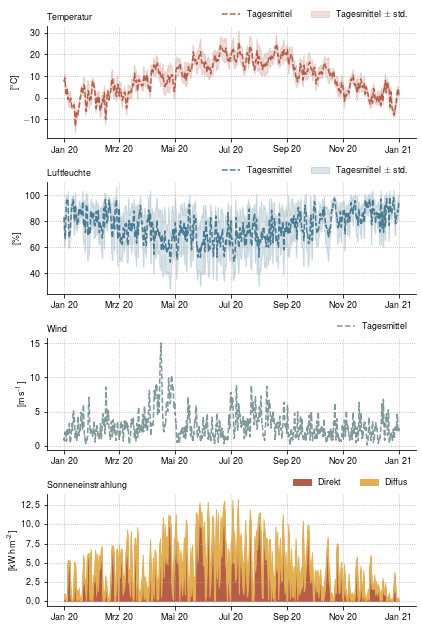

In [43]:
amb = makeAMBfromEPW('data/wetter/MUC_2020.epw')

fig, axs = plt.subplots(4,1,**RT.size(1.5))
i=0
#----#1: Temperaturen ----
axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\celsius}]')
axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed', label=r'Tagesmittel', c = RT.red)
upper = amb.T_amb.rolling('D').mean() + amb.T_amb.rolling('D').std()
lower = amb.T_amb.rolling('D').mean() - amb.T_amb.rolling('D').std()
x = upper.index
axs[i].fill_between(x, lower, upper, label=r'Tagesmittel $\pm$ std.', color = RT.red, alpha=0.2)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#2: Luftfeuchte ----
axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\percent}]')
axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed', label='Tagesmittel', c = RT.blue)
upper = amb.Rh_amb.rolling('D').mean() + amb.Rh_amb.rolling('D').std()
lower = amb.Rh_amb.rolling('D').mean() - amb.Rh_amb.rolling('D').std()
x = upper.index
axs[i].fill_between(x, lower, upper, label=r'Tagesmittel $\pm$ std.', color = RT.blue, alpha=0.2)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#3: Wind ----

axs[i].set_title('Wind', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\metre\per\second}]')
axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Tagesmittel', linestyle='dashed', c = RT.green, alpha=0.7)

axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#4: Globalstrahlung ----

axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\kilo\watt\hour\per\square\metre}]')
df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000
axs[i].fill_between(df_p.index, 0, df_p['direct'], color=RT.red, label = 'Direkt', alpha=1)
axs[i].fill_between(df_p.index, df_p['direct'], df_p['diffuse']+df_p['direct'],  color=RT.yellow, label = 'Diffus', alpha=1)
#axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=RT.red, label = 'Direkt', alpha=1)
#axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=RT.yellow, label = 'Diffus', alpha=1)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

for ax in axs:
    ax.grid(which='both')
    
fig.tight_layout()

Lade WetterDB...
exportiere die zuletzt verwendete Figure...


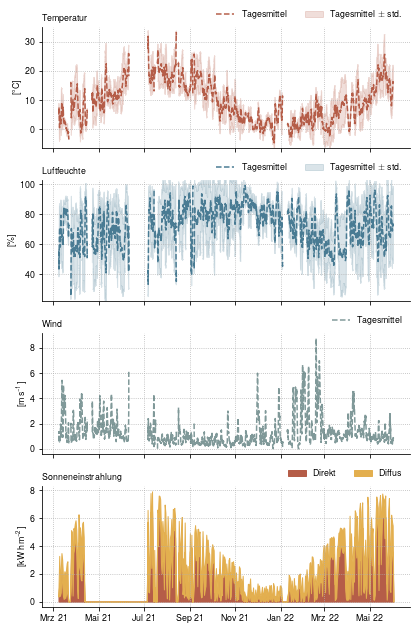

In [44]:
amb = getAMB()

fig, axs = plt.subplots(4,1,**RT.size(1.5), sharex=True)
i=0
#----#1: Temperaturen ----
axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\celsius}]')
axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed', label=r'Tagesmittel', c = RT.red)
upper = amb.T_amb.rolling('D').mean() + amb.T_amb.rolling('D').std()
lower = amb.T_amb.rolling('D').mean() - amb.T_amb.rolling('D').std()
x = upper.index
axs[i].fill_between(x, lower, upper, label=r'Tagesmittel $\pm$ std.', color = RT.red, alpha=0.2)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#2: Luftfeuchte ----
axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\percent}]')
axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed', label='Tagesmittel', c = RT.blue)
upper = amb.Rh_amb.rolling('D').mean() + amb.Rh_amb.rolling('D').std()
lower = amb.Rh_amb.rolling('D').mean() - amb.Rh_amb.rolling('D').std()
x = upper.index
axs[i].fill_between(x, lower, upper, label=r'Tagesmittel $\pm$ std.', color = RT.blue, alpha=0.2)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#3: Wind ----

axs[i].set_title('Wind', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\metre\per\second}]')
axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Tagesmittel', linestyle='dashed', c = RT.green, alpha=0.7)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#4: Globalstrahlung ----

axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\kilo\watt\hour\per\square\metre}]')

df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000
axs[i].fill_between(df_p.index, 0, df_p['direct'], color=RT.red, label = 'Direkt', alpha=1)
axs[i].fill_between(df_p.index, df_p['direct'], df_p['diffuse']+df_p['direct'],  color=RT.yellow, label = 'Diffus', alpha=1)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

for ax in axs:
    ax.grid(which='both')

fig.tight_layout()

### `.109`-Dateien

In [15]:
w = trnpy.weather109()
w.read_file(path='./data/wetter/template_weatherfile.109')
df1 = trnpy.PeriodToDatetimeIndex(w.df, 2005)
w.name = 'Wetterdaten_Bad_Aibling_TEST'
print(w.name)
w.df

Wetterdaten_Bad_Aibling_TEST


,IBEAM_H,IDIFF_H,TAMB,WSPEED,RHUM,WDIR,CCOVER,PAMB
1,0.0,0.0,0.1,2.8,89.0,30.0,8.0,969.1
2,0.0,0.0,0.1,2.1,89.0,10.0,8.0,970.4
3,0.0,0.0,0.1,1.5,89.0,10.0,8.0,971.2
4,0.0,0.0,0.1,1.4,86.0,70.0,8.0,970.9
5,0.0,0.0,0.1,1.0,86.0,50.0,8.0,970.5
...,...,...,...,...,...,...,...,...
8756,0.0,0.0,3.7,3.8,86.0,60.0,8.0,963.2
8757,0.0,0.0,2.5,4.7,80.0,90.0,8.0,963.8
8758,0.0,0.0,1.4,5.5,78.0,110.0,8.0,964.4
8759,0.0,0.0,0.6,5.0,80.0,100.0,8.0,965.8


In [16]:
AMB = getAMB()
df = trnpy.DatetimeToPeriodIndex(AMB.loc['2021'].resample('H').last()).fillna('ffill',downcast='float', axis=1)
df.head()

Lade WetterDB...


,T_amb,Rh_amb,windspeed,gustspeed,rain,winddir,global,direct,diffuse
Period,,,,,,,,,
1596,7.6,41.0,0.3,0.6,225.3,SE,0.24,0.0,0.24
1597,7.9,40.0,1.3,2.0,225.3,SE,0.24,0.0,0.24
1598,8.7,40.0,1.0,1.3,225.3,NW,609.12,378.84,230.28
1599,6.8,51.0,1.7,2.3,225.6,NW,306.72,90.36,216.36
1600,6.9,48.0,1.0,1.3,225.6,NE,133.2,19.08,114.12


4. Ersetze einzelne Werte durch Messwerte. 

*Achtung!* Nicht wirklich ausgereift.

In [17]:
w.Variables[2].update(AMB['direct'])

5. Speichere die Wetterdatei ab.

In [18]:
w.export()

Wetterdatei ./data/wetter\Wetterdaten_Bad_Aibling_TEST.109 wurde erfolgreich gespeichert"


## **Schedules**
___
Erstelle Schedules zum import in TRNLIZARD

### Tagesschedules

1. Erstelle eine (Tages-)Schedule Datenbank 

In [50]:
DailySchedules = trnpy.ScheduleCollection(mode='DAY')
DailySchedules

DAYSCHEDULE-COLLECTION: <0 Schedules>

2. Erstelle zwei Schedules und füge sie der Datenbank hinzu.

In [51]:
wd = trnpy.Schedule(Name='NATVENT_WD')
wd.setDomain(8.5,8.75,1)
wd.setDomain(18.25,18.5,1)
DailySchedules.add(wd)

we = trnpy.Schedule(Name='NATVENT_WE')
we.setDomain(8.5,8.75,1)
we.setDomain(18.25,18.5,1)
DailySchedules.add(we)
DailySchedules

DAYSCHEDULE-COLLECTION: <2 Schedules>

3. Übersicht über die angelegten Schedules

In [52]:
DailySchedules()

,0,1,2,3,4,5
NATVENT_WD,0.00 0.00,7.50 1.00,7.75 0.00,17.25 1.00,17.50 0.00,24.00 0.00
NATVENT_WE,0.00 0.00,7.50 1.00,7.75 0.00,17.25 1.00,17.50 0.00,24.00 0.00


4. Exportiere die Schedule-Collection ins Projektverzeichnis

In [56]:
DailySchedules.export('sim/robust-inputs')

Erfolgreich unter sim/robust-inputs\DAYSCHED_COLLECTION.csv gespeichert!


### Wochenschedule

1. Initialisiere Schedule-Collection

In [57]:
WeeklySchedules = trnpy.ScheduleCollection()
WeeklySchedules

WEEKSCHEDULE-COLLECTION: <0 Schedules>

2. Weise jedem Wochentag einen Daily-Schedule zu.

In [58]:
weekarray = [wd,wd,wd,wd,wd,we,we]
ws = trnpy.Weekschedule(Name='NATVENT')
ws.setWeek(weekarray)
ws.Daysarray
WeeklySchedules.add(ws)

# ws = trnpy.Weekschedule(Name='Test2')
# ws.setWeek(weekarray)
# ws.Daysarray
# WeeklySchedules.add(ws)

WeeklySchedules()

,0,1,2,3,4,5,6
NATVENT,NATVENT_WD,NATVENT_WD,NATVENT_WD,NATVENT_WD,NATVENT_WD,NATVENT_WE,NATVENT_WE


3. Speichere die Collection ab.

In [59]:
WeeklySchedules.export(dest='sim/robust-inputs/')

Erfolgreich unter sim/robust-inputs/WEEKSCHED_COLLECTION.csv gespeichert!


## **Erstelle die Varianten für die Simulation**
___

## Eine Klasse die mir die eine Variante erstellt. Die einzelnen Varianten werden dann in einem Pandas DataFrame gespeichert. 

1) Definiere die unsicheren Randbedinungen für die a Priori Monte-Carlo-Simulation

Anzahl unsicherer Randbedingungen: 3, Anzahl Ausprägungen: 1024


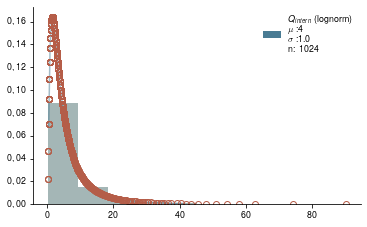

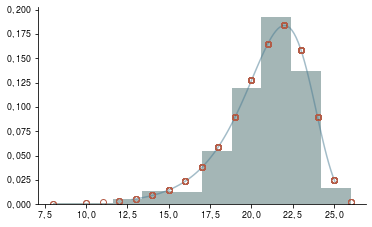

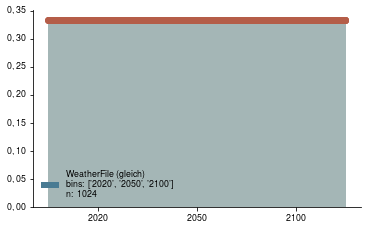

In [46]:
m = 10
unsichereRB = {
    'IntGain': trnpy.MC_variable(r'$Q_{intern}$', 'lognorm', m, Mu=4, Sigma=1, SampleRound=1),
    'Tset': trnpy.MC_variable(r'$T_{set}$', 'gumbel',m, Mu=22, Sigma=2, SampleRound=0.5),
    'WeatherFile': trnpy.MC_variable('WeatherFile','gleich',m, bins=['2020','2050','2100'])
    }

unsichereRB['IntGain'].plot()
unsichereRB['Tset'].plot()
unsichereRB['WeatherFile'].plot()

N_RB = len(unsichereRB)
N_RB_i = min(np.array([item.n for item in unsichereRB.values()]))
print(f'Anzahl unsicherer Randbedingungen: {N_RB}, Anzahl Ausprägungen: {N_RB_i}')

2) Definiere die sicheren Randbedinungungen. 
    
    `Hinweis: Jede sichere Randbedinung wird mit JEDER unsicheren Randbedinung kombiniert`

In [24]:
Varianten = {
    'bui': buid, 
    'FensterSignal': [
        *pd.read_csv('./sim/robust-inputs/MC_signal.csv').columns, 
        *pd.read_csv('./sim/robust-inputs/logreg_proba.csv').columns,
        'Reference'
        ]
        }

n_Varianten = [len(item) for item in Varianten.values()]
print(f'Anzahl Varianten: {len(Varianten)} mit {n_Varianten} Ausprägungen, bei {N_RB_i} Ausprägungen der Randbedinungen ergibt das {np.product([len(item) for item in Varianten.values()]) * N_RB_i} Simulationen')

Anzahl Varianten: 2 mit [4, 41] Ausprägungen, bei 1 Ausprägungen der Randbedinungen ergibt das 164 Simulationen


4) Erstelle eine Variable für eine *In Simulation* Monte Carlo simulation

In [22]:
# test = trnpy.MC_variable(r'$T_{set}$', 'gumbel', Mu=22.47, Sigma=1.13, Sample=[np.random.rand() for i in range(0,8761)],SampleRound=1)
# test.plot()

# df = pd.concat([pd.Series(test.sample, name='Tset_Sample')],axis=1).round(2)
# df.to_csv('./sim/robust-inputs/HourlyVariable_Test.csv', index=False, sep=' ')

Exportiere die erstellten Varianten nach TRNLizard

In [31]:
Simulationen = trnpy.VariantCollection()
Simulationen.MonteCarloVariants(
    SimName='RomansThesis', 
    Varianten = Varianten, 
    unsichereRB = unsichereRB
    )
Simulationen.export()
Simulationen()

,ACR_inf,ActiveLayer,Ceiling,ExtWall,FBH,FensterModel,FensterSignal,Floor,IntGain,IntWall_H,IntWall_L,Laibung,SV_ON,SV_T_OFF,SV_T_ON,THB,Tset,WeatherFile,WindowID,bui
Name,,,,,,,,,,,,,,,,,,,,
RomansThesis_0,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_0,BO,6.0,LB_IW_H,LB_IW_L,0.50,-20,-20.0,-20.0,0.018,20.0,MUC_2020.epw,3307,LB
RomansThesis_1,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_1,BO,6.0,LB_IW_H,LB_IW_L,0.50,-20,-20.0,-20.0,0.018,20.0,MUC_2020.epw,3307,LB
RomansThesis_2,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_2,BO,6.0,LB_IW_H,LB_IW_L,0.50,-20,-20.0,-20.0,0.018,20.0,MUC_2020.epw,3307,LB
RomansThesis_3,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_3,BO,6.0,LB_IW_H,LB_IW_L,0.50,-20,-20.0,-20.0,0.018,20.0,MUC_2020.epw,3307,LB
RomansThesis_4,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_4,BO,6.0,LB_IW_H,LB_IW_L,0.50,-20,-20.0,-20.0,0.018,20.0,MUC_2020.epw,3307,LB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RomansThesis_159,0,0,GEG_DA,GEG_AW,FBH_DUMMY,LogReg,LogReg_PROBA_16,GEG_BO,6.0,GEG_IW_H,GEG_IW_L,0.36,-20,-20.0,-20.0,0.050,20.0,MUC_2020.epw,3307,GEG
RomansThesis_160,0,0,GEG_DA,GEG_AW,FBH_DUMMY,LogReg,LogReg_PROBA_17,GEG_BO,6.0,GEG_IW_H,GEG_IW_L,0.36,-20,-20.0,-20.0,0.050,20.0,MUC_2020.epw,3307,GEG
RomansThesis_161,0,0,GEG_DA,GEG_AW,FBH_DUMMY,LogReg,LogReg_PROBA_18,GEG_BO,6.0,GEG_IW_H,GEG_IW_L,0.36,-20,-20.0,-20.0,0.050,20.0,MUC_2020.epw,3307,GEG


Öffne gespeicherte Varianten

In [363]:
Simulationen = trnpy.VariantCollection()
Simulationen.open()
Simulationen()

,ACR_inf,ActiveLayer,Ceiling,ExtWall,FBH,FensterModel,FensterSignal,Floor,IntGain,IntWall_H,IntWall_L,Laibung,SV_ON,SV_T_OFF,SV_T_ON,THB,Tset,WeatherFile,WindowID,bui
Name,,,,,,,,,,,,,,,,,,,,
RomansThesis_0,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_0,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_1,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_1,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_2,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_2,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_3,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_3,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_4,0,0,DA,LB_AW,FBH_DUMMY,MC,MC_SIG_4,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_5,0,0,DA,LB_AW,FBH_DUMMY,LogReg,LogReg_PROBA_0,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_6,0,0,DA,LB_AW,FBH_DUMMY,LogReg,LogReg_PROBA_1,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_7,0,0,DA,LB_AW,FBH_DUMMY,LogReg,LogReg_PROBA_2,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB
RomansThesis_8,0,0,DA,LB_AW,FBH_DUMMY,LogReg,LogReg_PROBA_3,BO,0.8,LB_IW_H,LB_IW_L,0.500,-20,-20.0,-20.0,0.018,21.0,MUC_2050.epw,3307,LB


# **Auswertung der Simulation**
[--> Zurück zum Anfang](#importe)

In [1]:
ebtotrn = {
    'T_amb': 'Tamb [C]', 
    'T_amb_g24': 'Tamb_g24', 
    'Tair':'Tair_A_Wohnen', 
    'CO2': 'CO2_A_Wohnen [ppm]'
    }

def descfunc_from_results(params, prn):
    exogs = pd.concat({exog: prn.filter(like=ebtotrn[exog]).squeeze() for exog in list(params.columns)}, axis=1)
    intercept = params.loc['intercept'].max()
    x0 = exogs.sub(params.loc['mean'], axis=1).div(params.loc['scale']).dot(params.loc['coeff'])
    print(exogs.agg(['mean', 'std']).round(2))
    return x0

## Lade einzelne Simulation

In [2]:
prn = trnpy.read_prn('sim/Model/RomansThesis_40/Results/AddOutput_1h.prn', 'dt')
prn.head()

NameError: name 'trnpy' is not defined

## Lade alle Simulationsvarianten

In [2]:
RESULTS = trnpy.SIMRESULTS('sim/Model', focus_variables=['bui', 'WeatherFile', 'FensterModel', 'IntGain', 'ACR_inf', 'Tset'])
RESULTS.Summary

RomansThesis
Lade PRN-Sheets...
Alle Varianten vollständig importiert                                                                                      


,bui,WeatherFile,FensterModel,IntGain,ACR_inf,Tset,DQAIRdt,QHEAT,QINF,QVENT,QTRANS,QGAININT,QSOLGAIN,QSOLAIR,UTGS_EN,ÜTGS_EN,UTGS_NA,ÜTGS_NA
RomansThesis_0,LB,MUC_2020.epw,MC,6.0,0,20.0,NaN,26.05,-18.68,-19.98,-30.57,29.05,13.00,1.11,2.0,380.0,3416.0,6605.0
RomansThesis_1,LB,MUC_2020.epw,MC,6.0,0,20.0,-0.01,21.20,-18.26,-16.64,-29.54,29.12,13.00,1.11,57.0,184.0,2819.0,4483.0
RomansThesis_2,LB,MUC_2020.epw,MC,6.0,0,20.0,NaN,21.16,-18.69,-14.94,-30.69,29.05,13.00,1.11,0.0,141.0,2260.0,5186.0
RomansThesis_3,LB,MUC_2020.epw,MC,6.0,0,20.0,NaN,20.42,-18.93,-13.63,-30.99,29.02,13.00,1.11,3.0,318.0,2234.0,5920.0
RomansThesis_4,LB,MUC_2020.epw,MC,6.0,0,20.0,NaN,22.23,-18.53,-16.53,-30.37,29.08,13.00,1.11,3.0,360.0,2482.0,4636.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RomansThesis_159,GEG,MUC_2020.epw,LogReg,6.0,0,20.0,-0.01,32.03,-16.73,-33.19,-22.67,24.92,14.39,1.23,402.0,1239.0,9492.0,5440.0
RomansThesis_160,GEG,MUC_2020.epw,LogReg,6.0,0,20.0,-0.01,32.25,-16.64,-33.67,-22.52,24.96,14.39,1.23,345.0,1169.0,9583.0,5366.0
RomansThesis_161,GEG,MUC_2020.epw,LogReg,6.0,0,20.0,-0.01,32.44,-16.62,-33.93,-22.49,24.98,14.39,1.23,496.0,1205.0,9936.0,5480.0
RomansThesis_162,GEG,MUC_2020.epw,LogReg,6.0,0,20.0,-0.01,32.80,-16.59,-34.43,-22.39,24.99,14.39,1.23,505.0,1163.0,9965.0,5400.0


In [ ]:
RESULTS.Summary[RESULTS.Summary['FensterModel'] == 'Reference']

,bui,WeatherFile,FensterModel,IntGain,ACR_inf,Tset,DQAIRdt,QHEAT,QINF,QVENT,QTRANS,QGAININT,QSOLGAIN,QSOLAIR,UTGS_EN,ÜTGS_EN,UTGS_NA,ÜTGS_NA
RomansThesis_40,LB,MUC_2020.epw,Reference,6.0,0,20.0,NaN,18.02,-17.89,-14.14,-29.29,29.18,13.00,1.11,0.0,0.0,1675.0,453.0
RomansThesis_81,MH,MUC_2020.epw,Reference,6.0,0,20.0,NaN,16.63,-18.34,-16.83,-26.01,28.19,15.05,1.29,0.0,1.0,2523.0,3105.0
RomansThesis_122,MW,MUC_2020.epw,Reference,6.0,0,20.0,NaN,16.59,-18.26,-14.25,-27.13,28.37,13.53,1.16,0.0,39.0,1884.0,3592.0
RomansThesis_163,GEG,MUC_2020.epw,Reference,6.0,0,20.0,NaN,19.93,-18.18,-15.70,-25.96,24.31,14.39,1.23,0.0,262.0,2789.0,4689.0


Wähle zufällige Varainten nach FensterModel aus. Wähle eine Variante der Gruppe LogReg
Ich nehme: RomansThesis_156
exportiere die zuletzt verwendete Figure...


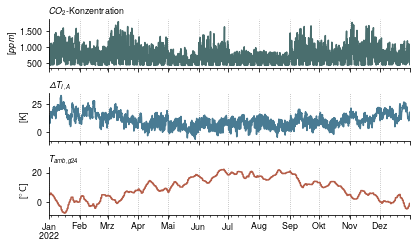

In [ ]:
df = RESULTS.getRandom('FensterModel', choice='LogReg')
fig, axs = plt.subplots(3,1, **RT.size(.6), sharex=True)
ax = df['CO2 [ppm]', 'Wohnen'].plot(ax=axs[0], color=RT.green)
ax.set(title=r'$CO_2$-Konzentration', ylabel=r'$[ppm]$')
ax.grid(axis='x')
ax = (df['Tair [C]', 'Wohnen'] - df['Tamb [C]', 'Amb']).plot(ax=axs[1])
ax.set(title=r'$\Delta T_{I,A}$', ylabel=r'$[\si{\kelvin}]$')
ax.grid(axis='x')
ax = df['Tamb_g24 [C]', 'Amb'].plot(ax=axs[2], color=RT.red)
ax.set(title=r'$T_{amb,g24}$', ylabel=r'$[\si{\celsius}]$', xlabel='')
ax.grid(axis='x')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
fig.tight_layout()

exportiere die zuletzt verwendete Figure...


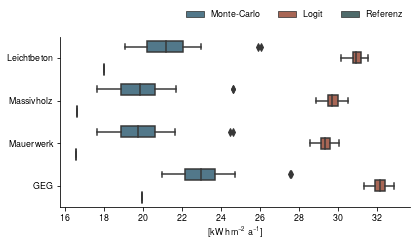

In [140]:
fig = plt.figure(**RT.size(.6))
ax = sns.boxplot(data=RESULTS.Summary.replace(RT.NAMES), y='bui', x='QHEAT',hue='FensterModel')
ax.legend(title=None, bbox_to_anchor=(1,1.2), loc='upper right', ncol=3)
ax.set(ylabel=None, xlabel=r'[\si{\kilo\watt\hour\per\square\metre\per\year}]')
fig.tight_layout()

<bound method Figure.tight_layout of <Figure size 422.362x168.945 with 1 Axes>>

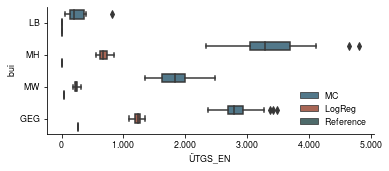

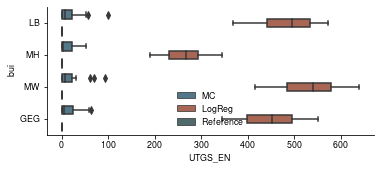

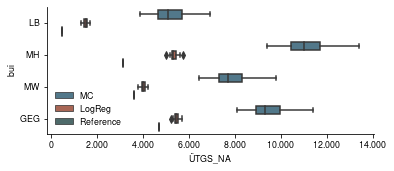

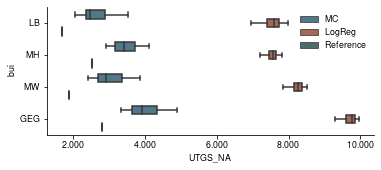

In [141]:
fig = plt.figure(**RT.size(.4))
ax = sns.boxplot(data=RESULTS.Summary, y='bui', x='ÜTGS_EN', hue='FensterModel')
ax.legend(title=None)
fig.tight_layout

fig = plt.figure(**RT.size(.4))
ax = sns.boxplot(data=RESULTS.Summary, y='bui', x='UTGS_EN', hue='FensterModel')
ax.legend(title=None)
fig.tight_layout

fig = plt.figure(**RT.size(.4))
ax = sns.boxplot(data=RESULTS.Summary, y='bui', x='ÜTGS_NA', hue='FensterModel')
ax.legend(title=None)
fig.tight_layout

fig = plt.figure(**RT.size(.4))
ax = sns.boxplot(data=RESULTS.Summary, y='bui', x='UTGS_NA', hue='FensterModel')
ax.legend(title=None)
fig.tight_layout

In [119]:
df = RESULTS.getValue('ACR_sv1 [1/h]', Airnode='Wohnen').droplevel(1,axis=1).gt(0).resample('D').sum().groupby([RESULTS.VariantCollection.bui, RESULTS.VariantCollection.FensterModel], axis=1).mean().mean().unstack().round(2)
fig = plt.figure(**RT.size(aspect=0.25))
ax = sns.heatmap(data=df.rename(columns=RT.NAMES, index=RT.NAMES).round(1), cmap=RT.HEATMAP, center=0, annot=True, fmt='.3n', cbar_kws=dict(label=r'[\si{1\per\hour}]'))
ax.set(ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
fig.tight_layout()

FensterModel,LogReg,MC,Reference
bui,,,
GEG,14.800000,3.390000,2.000000
LB,14.810000,3.390000,2.000000
MH,14.710000,3.390000,2.000000
MW,14.790000,3.390000,2.000000


In [117]:
RESULTS.variables.append('ACR_SV')

exportiere die zuletzt verwendete Figure...


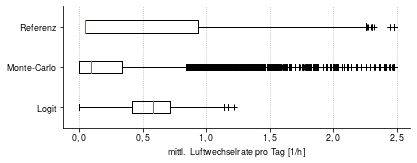

In [139]:
data = {kind: group.stack().droplevel(1).to_numpy() for kind, group in RESULTS.getValue('ACR_SV', Airnode='Wohnen').resample('D').mean().droplevel(1, axis=1).groupby(RESULTS.Summary.replace(RT.NAMES).FensterModel, axis=1)}
fig, ax = plt.subplots(**RT.size(.4))
ax.boxplot(x = data.values(), labels=data.keys(), vert=False, sym='+')
ax.grid(axis='x')
ax.set(ylabel=None, xlabel=r'mittl. Luftwechselrate pro Tag [\si{1\per\hour}]')
fig.tight_layout()

exportiere die zuletzt verwendete Figure...


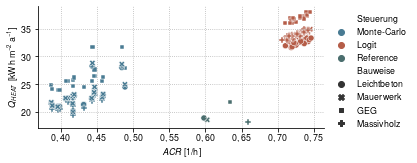

In [ ]:
df = RESULTS.getValue(['ACR_tot [1/h]', 'Q_tot_ht [W/m2]'], Airnode='Wohnen').agg(['mean', 'sum']).stack(0).unstack(0).rename(columns= lambda x: x.split(' ')[0])[[('ACR_tot', 'mean'), ('Q_tot_ht', 'sum')]].droplevel(1, axis=1).join(RESULTS.Summary[['FensterModel', 'bui']])
df['Q_tot_ht'] /= 1000
df = df.rename(columns={'FensterModel': 'Steuerung', 'bui': 'Bauweise'}).replace(RT.NAMES)
fig = plt.figure(**RT.size(.4))
ax = sns.scatterplot(data=df, x='ACR_tot', y='Q_tot_ht', hue='Steuerung', style='Bauweise')
ax.grid()
ax.legend(title=None, bbox_to_anchor=(1,1), loc='upper left')
ax.legend
ax.set(ylabel=r'$Q_{HEAT}$ [\si{\kilo\watt\hour\per\square\metre\per\year}]', xlabel=r'$ACR$ [\si{1\per\hour}]')
fig.tight_layout()

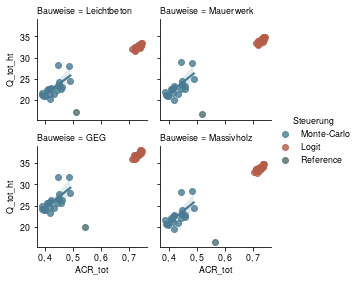

In [ ]:
sns.lmplot(data=df, x='ACR_tot', y='Q_tot_ht', hue='Steuerung', col='Bauweise', height=2, aspect=1, col_wrap=2)

MC, LB: 0.45 1/h
MC, LB: 23.2 kWh/m²*a


exportiere die zuletzt verwendete Figure...


LogReg, LB: 0.73 1/h
LogReg, LB: 32.6 kWh/m²*a


exportiere die zuletzt verwendete Figure...


Reference, LB: 0.6 1/h
Reference, LB: 19.0 kWh/m²*a


exportiere die zuletzt verwendete Figure...


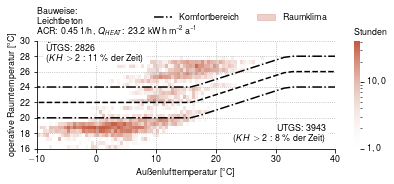

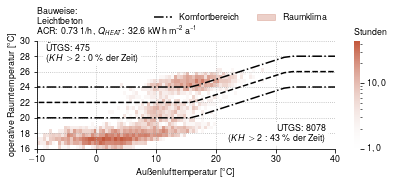

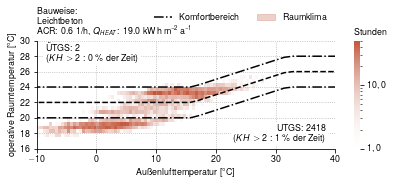

In [20]:
Vergleich = RESULTS.getRandom('FensterModel', where=(lambda s: s.bui == 'LB'), Airnode=['Wohnen', 'Amb'])
for model, df in Vergleich.items():
    varname = df.columns.get_level_values(0).unique()[0]
    bui = RESULTS.Summary.at[varname, 'bui']
    df = df.droplevel(0, axis=1)

    print(f"{model}, {bui}: {df['ACR_tot [1/h]', 'Wohnen'].mean():.2} 1/h")
    print(f"{model}, {bui}: {df['Q_tot_ht [W/m2]', 'Wohnen'].sum()/1000:.3} kWh/m²*a")

    _top = df['Top [C]', 'Wohnen'].between_time('18:00', '08:00')
    _tamb = df['Tamb [C]'].between_time('18:00', '08:00')
    _tair = df['Tair [C]', 'Wohnen'].between_time('18:00', '08:00')
    _rH = df['Rh [%]', 'Wohnen'].between_time('18:00', '08:00')
    _title = f'Bauweise:\n{RT.NAMES[bui]}\n ACR: {df["ACR_tot [1/h]", "Wohnen"].mean():.2} \\si{{1\\per\\hour}}, $Q_{{HEAT}}$: {df["Q_tot_ht [W/m2]", "Wohnen"].sum()/1000:.3} \\si{{\\kilo\\watt\\hour\\per\\square\\metre\\per\\year}}'

    fig, ax = plt.subplots(**RT.size(.45))
    hx = RT.comf.hxdiagramm(rh=_rH, temp=_tair,ax=ax, kind='hist', title=_title , label=model)

    fig, ax = plt.subplots(**RT.size(.45))
    RT.comf.adaptive_comfort_NA(Tamb=_tamb, Top=_top, ax=ax, kind='hist', scale='log', title=_title)

    fig, ax = plt.subplots(**RT.size(.45))
    RT.comf.adaptive_comfort_EN(Tamb=_tamb, Top=_top, ax=ax, kind='hist', scale='log', title=f'Bauweise: {RT.NAMES[bui]}')


exportiere die zuletzt verwendete Figure...


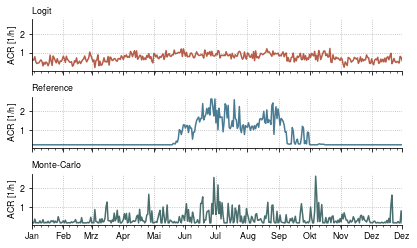

In [ ]:
fig, ax = plt.subplots(**RT.size(0.6))
Vergleich = RESULTS.getRandom('FensterModel', where=(lambda s: s.bui == 'LB'), Airnode=['Wohnen', 'Amb'])
data = pd.concat(Vergleich, axis=1).filter(like='ACR_tot').resample('D').mean().droplevel([1,2,3], axis=1).rename(columns=RT.NAMES)
data.plot(ax=ax, subplots=True, ylabel=r'ACR [\si{1\per\hour}]', grid='x', xlabel='', title=list(data.columns), sharex=True, sharey=True, legend=False, color={'Logit':RT.red, 'Reference':RT.blue, 'Monte-Carlo':RT.green})
plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
fig.tight_layout()

exportiere die zuletzt verwendete Figure...


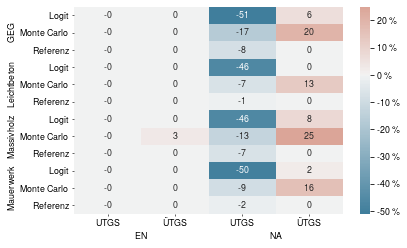

In [157]:
data = RESULTS.Kelvinstunden.between_time('18:00', '08:00').loc[:,pd.IndexSlice[:,'Wohnen',:]].gt(2).sum().div((14/24)*87.60).unstack(0).droplevel(0).T.groupby([RESULTS.Summary.bui, RESULTS.Summary.FensterModel]).mean().rename(columns=lambda x: '-'.join(reversed(x.split('_'))), index=RT.NAMES).round(0)
data.loc[:,data.filter(like='UTGS').columns] *= -1
fig = plt.figure(**RT.size(aspect=0.6))
ax = sns.heatmap(data=data, cmap=RT.HEATMAP, center=0, annot=True, fmt='4n', cbar_kws=dict(format=mpl.ticker.StrMethodFormatter(r'{x:1n} \%')))
RT.cleanBuiAppAxis(ax)
RT.cleanBuiAppAxis(ax, 'y')
ax.tick_params(axis='y', which='major', length=55)
fig.tight_layout()

exportiere die zuletzt verwendete Figure...


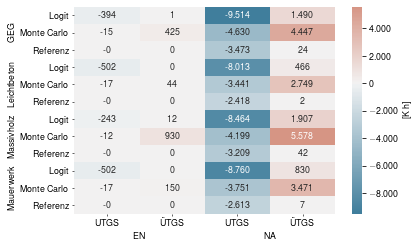

In [158]:
data = RESULTS.Kelvinstunden.between_time('18:00', '08:00').loc[:,pd.IndexSlice[:,'Wohnen',:]].sum().unstack(0).droplevel(0).T.groupby([RESULTS.Summary.bui, RESULTS.Summary.FensterModel]).mean().rename(columns=lambda x: '-'.join(reversed(x.split('_'))), index=RT.NAMES).round(0)
data.loc[:,data.filter(like='UTGS').columns] *= -1
fig = plt.figure(**RT.size(aspect=0.6))
ax = sns.heatmap(data=data, cmap=RT.HEATMAP, center=0, annot=True, fmt='4n', cbar_kws=dict(label=r'[\si{\kelvin\hour}]'))
RT.cleanBuiAppAxis(ax)
RT.cleanBuiAppAxis(ax, 'y')
ax.tick_params(axis='y', which='major', length=55)
fig.tight_layout()